In [2]:
import os, warnings, logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, classification_report

from minisom import MiniSom
from sklearn.cluster import KMeans


In [4]:
# CSV dosyasını oku
df = pd.read_csv("Credit_Card_Applications.csv")

print(df.shape)
print(df.head(3))

# Sütunlar tipik olarak: ['Time','V1'..'V28','Amount','Class']
assert "Class" in df.columns, "Class etiketi bulunamadı"
y = df["Class"].values.astype(int)

# Özellik matrisi
X = df.drop(columns=["Class"])


(690, 16)
   CustomerID  A1     A2     A3  A4  A5  A6     A7  A8  A9  A10  A11  A12  \
0    15776156   1  22.08  11.46   2   4   4  1.585   0   0    0    1    2   
1    15739548   0  22.67   7.00   2   8   4  0.165   0   0    0    0    2   
2    15662854   0  29.58   1.75   1   4   4  1.250   0   0    0    1    2   

   A13   A14  Class  
0  100  1213      0  
1  160     1      0  
2  280     1      0  


In [5]:
# "Amount" ve "Time" ölçeklenir; V1..V28 zaten PCA-türevi (ama yine de standardization faydalıdır)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Opsiyonel PCA: %95 varyansı koru (dilersen kapatabilirsin)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Orijinal boyut:", X_scaled.shape[1], "-> PCA boyutu:", X_pca.shape[1])

Orijinal boyut: 15 -> PCA boyutu: 14


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((552, 14), (138, 14), 0.44565217391304346, 0.4420289855072464)

In [7]:
m, n = 20, 20                   # SOM ızgara boyutu (20x20)
input_len = X_train.shape[1]    # PCA sonrası özellik sayısı
sigma = 2.0
lr = 0.5

som = MiniSom(x=m, y=n, input_len=input_len, sigma=sigma, learning_rate=lr,
              neighborhood_function='gaussian', random_seed=42)

som.random_weights_init(X_train)
print("SOM init tamam.")

# Eğitim (iteration = yaklaşık 10 * num_samples iyi bir başlangıç)
iterations = 10 * X_train.shape[0]
som.train_random(X_train, iterations, verbose=True)
print("SOM eğitim bitti.")


SOM init tamam.
 [ 5520 / 5520 ] 100% - 0:00:00 left 
 quantization error: 1.508507476959795
SOM eğitim bitti.


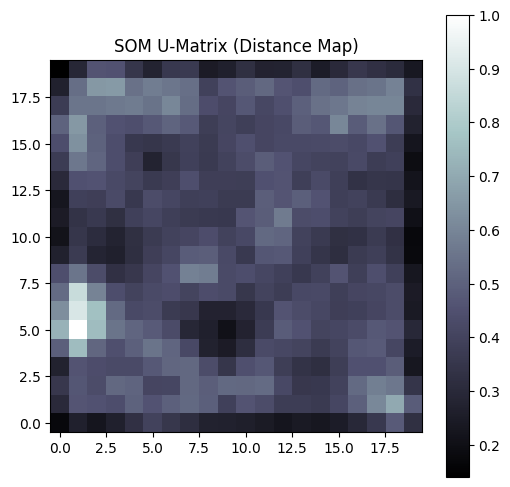

In [8]:
u_matrix = som.distance_map()  # (m, n)

plt.figure(figsize=(6,6))
plt.imshow(u_matrix.T, cmap="bone", origin="lower")
plt.title("SOM U-Matrix (Distance Map)")
plt.colorbar()
plt.show()


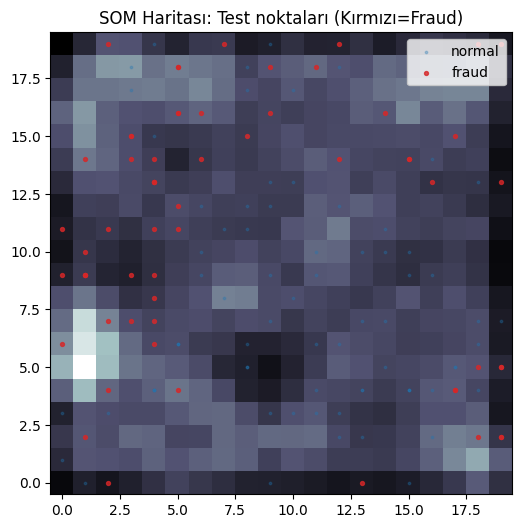

In [9]:
# Test verisini BMU'lara (best matching unit) yerleştir
bmu_coords = np.array([som.winner(x) for x in X_test])   # (N_test, 2)

fraud_idx = np.where(y_test==1)[0]
normal_idx = np.where(y_test==0)[0]

plt.figure(figsize=(6,6))
plt.imshow(u_matrix.T, cmap="bone", origin="lower")
plt.scatter(bmu_coords[normal_idx,0], bmu_coords[normal_idx,1], s=3, c="tab:blue", alpha=0.3, label="normal")
plt.scatter(bmu_coords[fraud_idx,0],  bmu_coords[fraud_idx,1],  s=8, c="tab:red",  alpha=0.8, label="fraud")
plt.legend(loc="upper right")
plt.title("SOM Haritası: Test noktaları (Kırmızı=Fraud)")
plt.show()


SOM Anomaly Score -> ROC-AUC: 0.5900 | PR-AUC: 0.5483


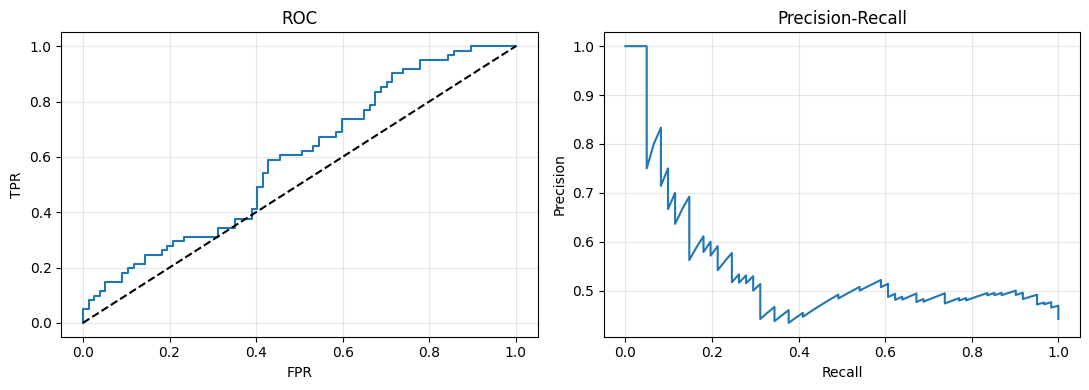

In [10]:
# Ağırlık matrisinden BMU vektörünü alıp örnekle arasındaki mesafe
def som_quantization_error(som, x):
    w = som.get_weights()  # (m, n, input_len)
    bmu = som.winner(x)
    w_bmu = w[bmu]         # (input_len,)
    return np.linalg.norm(x - w_bmu)

# Test set skorları
scores_test = np.array([som_quantization_error(som, x) for x in X_test])

# ROC-AUC ve PR-AUC (etikete göre)
roc = roc_auc_score(y_test, scores_test)
ap  = average_precision_score(y_test, scores_test)
print(f"SOM Anomaly Score -> ROC-AUC: {roc:.4f} | PR-AUC: {ap:.4f}")

# PR eğrisi / ROC eğrisi
prec, rec, thr = precision_recall_curve(y_test, scores_test)
fpr, tpr, _ = roc_curve(y_test, scores_test)

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.grid(alpha=0.3)
plt.subplot(1,2,2)
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall"); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()


In [11]:
def topk_threshold(scores, top_ratio=0.01):
    k = max(1, int(len(scores)*top_ratio))
    return np.sort(scores)[-k]

th = topk_threshold(scores_test, top_ratio=0.01)  # en anormal %1
y_pred = (scores_test >= th).astype(int)

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.5620    1.0000    0.7196        77
           1     1.0000    0.0164    0.0323        61

    accuracy                         0.5652       138
   macro avg     0.7810    0.5082    0.3759       138
weighted avg     0.7556    0.5652    0.4158       138



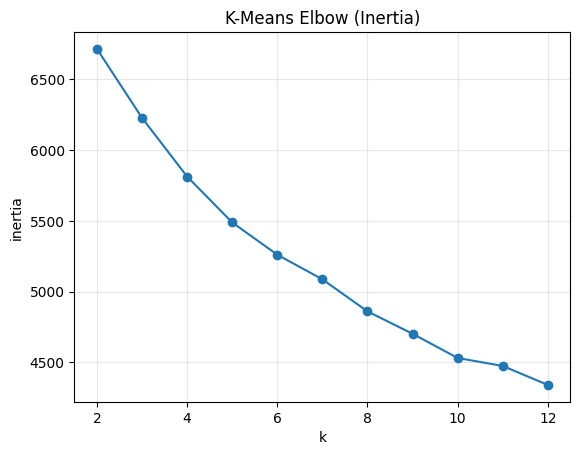

,cluster,fraud_rate
0,0,1.000000
6,6,0.950000
4,4,0.866667
3,3,0.789474
5,5,0.300000
7,7,0.230769
1,1,0.093750
2,2,0.066667


In [12]:
# Elbow grafiği (inertia)
inertias, ks = [], range(2, 13)
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_train)
    inertias.append(km.inertia_)

plt.plot(ks, inertias, marker="o")
plt.title("K-Means Elbow (Inertia)")
plt.xlabel("k"); plt.ylabel("inertia"); plt.grid(alpha=0.3)
plt.show()

# Örnek bir k ile test kümeleri ve fraud oranları
k = 8
km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_train)
test_labels = km.predict(X_test)

# Her kümede fraud oranı
fraud_rates = []
for i in range(k):
    idx = (test_labels == i)
    if idx.sum() > 0:
        fraud_rate = y_test[idx].mean()
    else:
        fraud_rate = np.nan
    fraud_rates.append(fraud_rate)

pd.DataFrame({"cluster": range(k), "fraud_rate": fraud_rates}).sort_values("fraud_rate", ascending=False)
